In [155]:
import numpy as np
import warnings
import scipy
import pandas as pd
from pandas import Series
from matplotlib import pyplot
import math
import random
import sklearn
from sklearn import metrics
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import Imputer 
from pyramid.arima import auto_arima

#april = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_april_staging_delayed_joined.csv')
#feb = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_feb_staging_delayed_joined.csv')
cpu = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_cpu_EAP_feb_june_mondolezprod.csv')
mem = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_mem_EAP_feb_june_mondolezprod.csv')
mem.head(10)
cpu.dtypes

_time          object
avg(Value)    float64
dtype: object

### Data Analysis

In [46]:
cpu['time'] = pd.to_datetime(cpu['_time'])
cpu_time = cpu.set_index(cpu['time'])
del cpu_time['time']
del cpu_time['_time']
mem['time'] = pd.to_datetime(mem['_time'])
mem_time = mem.set_index(mem['time'])
del mem_time['time']
del mem_time['_time']
cpu_time.head(5)


,avg(Value)
time,
2018-02-13 00:00:00,NaN
2018-02-13 01:00:00,55.333333
2018-02-13 02:00:00,50.000000
2018-02-13 03:00:00,42.333333
2018-02-13 04:00:00,43.000000


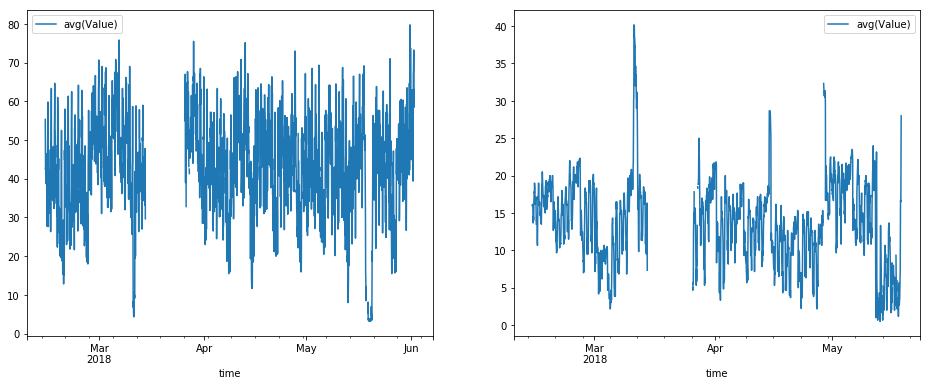

In [47]:

plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_time.plot(ax=ax1)
mem_time.plot(ax=ax2)
plt.show()

There are missing values for both time series, corresponding to the same time periods. There are several methods we can use to impute the missing values. Below shows a few methods. 

The first method is to compute the mean of the entire time series and assign the calculated mean to the missing values.

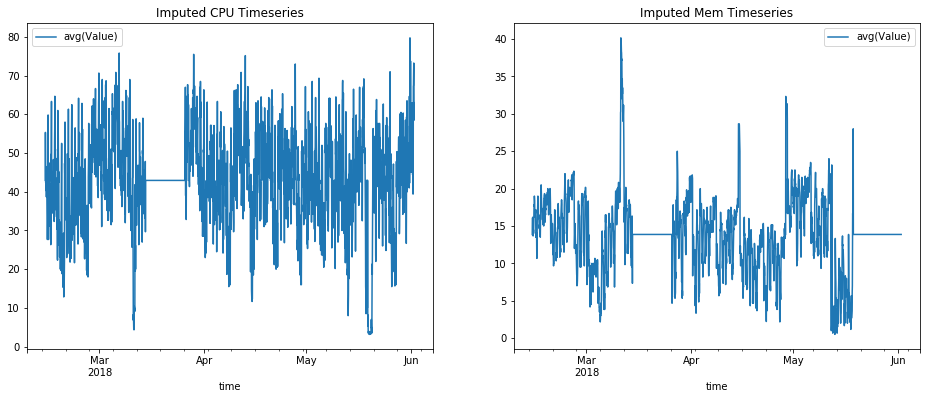

In [51]:
## Adding values based on the overall mean of the column
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_filled = cpu_time.fillna(cpu_time.mean())
mem_filled = mem_time.fillna(mem_time.mean())
cpu_filled.plot(ax=ax1, kind='line', title='Imputed CPU Timeseries')
mem_filled.plot(ax=ax2, kind='line', title='Imputed Mem Timeseries')

There are many drawbacks of using this very simple method. Firstly, using the mean computed over the entire time series results in one static value. Currently we are using this one static value across all time steps within the time series. Secondly, calculating the mean over the whole time series averages out any temporal affects that would otherwise be present in the 'real' time series. 

One other method we can use is linear interpolation. This calculates a linear range of values depending on the first and the last values surrounding the missing values. 

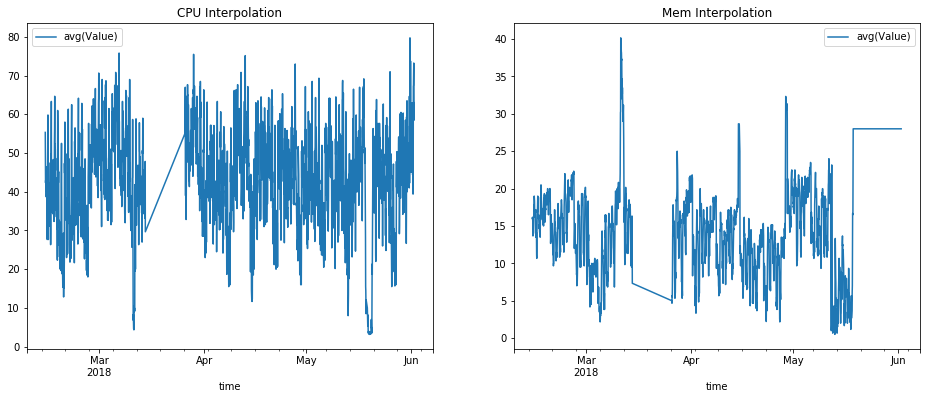

In [55]:
## Interpolating values based on linear interpolation
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_inter = cpu_time.interpolate(method='linear')
mem_inter = mem_time.interpolate(method='linear')
cpu_inter.plot(ax=ax1, kind='line', title='CPU Interpolation')
mem_inter.plot(ax=ax2, kind='line', title='Mem Interpolation')
plt.show()

The linear interpolation misses the fluctuations we might expect the time series to exhibit within the missing range. However, this very simple method at least captures the overall trend we might expect the values to exhibit across the missing time steps. 


Next, in order to check if our time series is stationary, we can calculate the moving average and variance exhibited over time. 

<Figure size 1152x432 with 0 Axes>

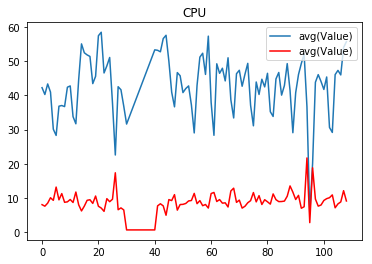

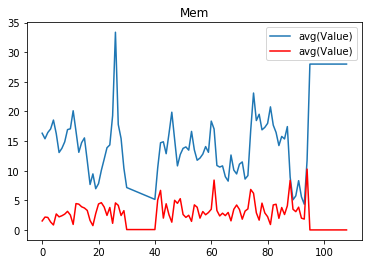

In [62]:
# Mean and variance over time - Calculate for every 24 folds within the total set of data points
plt.figure(figsize=(16,6))

cpu_average = cpu_inter.groupby(np.arange(len(cpu_inter))//24).mean()
cpu_std = cpu_inter.groupby(np.arange(len(cpu_inter))//24).std()

ax1=cpu_average.plot(kind='line', legend='Mean CPU')
cpu_std.plot(ax=ax1, kind='line', color='red', legend='Variance CPU', title='CPU')

mem_average = mem_inter.groupby(np.arange(len(mem_inter))//24).mean()
mem_std = mem_inter.groupby(np.arange(len(mem_inter))//24).std()
ax2 = mem_average.plot(kind='line', legend='Mean Mem')
mem_std.plot(ax=ax2, kind='line', color='red', legend='Variance Mem', title='Mem')
plt.show()

In [63]:
split = int(len(cpu_inter) / 4)
cpu_values = cpu_inter['avg(Value)']
mem_values = mem_inter['avg(Value)']
cpu_means = []
mem_means = []
cpu_variances = []
mem_variances = []
for i,j in zip(range(4),range(1,5)):
    l = i * split 
    k = j * split 
    X1 = cpu_values[l:k]
    X2 = mem_values[l:k]
    cpu_mean, cpu_var = X1.mean(), X1.var()
    mem_mean, mem_var = X2.mean(), X2.var()
    print('cpu mean1=%f, mem mean1=%f' % (cpu_mean,mem_mean))
    print('cpu variance1=%f, mem_var = %f' % (cpu_var, mem_var))
    cpu_means.append(cpu_mean)
    cpu_variances.append(cpu_var)
    mem_means.append(mem_mean)
    mem_variances.append(mem_var)
    

cpu mean1=42.708780, mem mean1=14.959035
cpu variance1=164.659821, mem_var = 33.897912
cpu mean1=43.742907, mem mean1=11.016607
cpu variance1=92.917797, mem_var = 27.616692
cpu mean1=43.593315, mem mean1=13.651546
cpu variance1=128.814091, mem_var = 29.309446
cpu mean1=41.044869, mem mean1=19.965715
cpu variance1=220.808167, mem_var = 91.338194


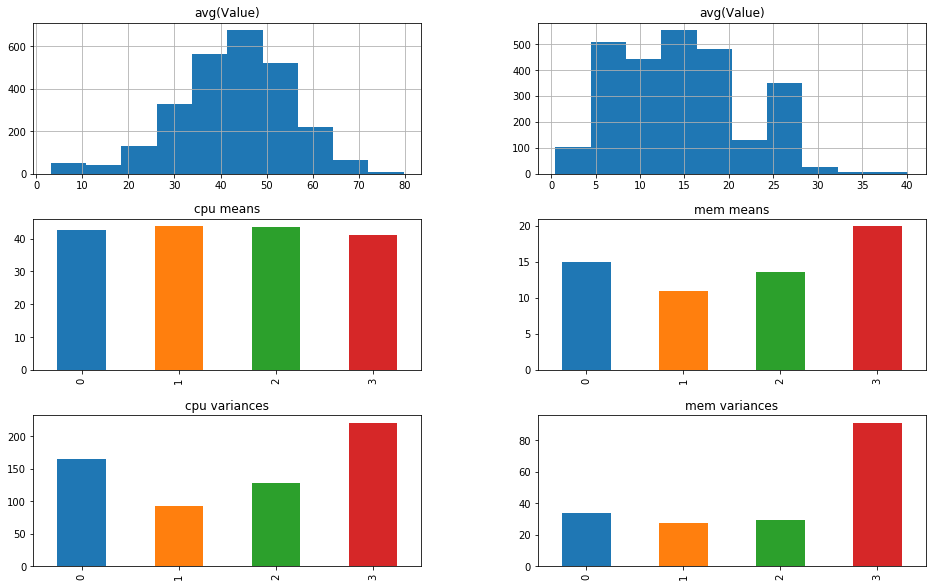

In [69]:
cpu_means = pd.Series(cpu_means)
cpu_variances = pd.Series(cpu_variances)
mem_means = pd.Series(mem_means)
mem_variances = pd.Series(mem_variances)
fg, axarr = plt.subplots(3,2, figsize=(16,10))
cpu_inter.hist(ax=axarr[0,0])
mem_inter.hist(ax=axarr[0,1])
cpu_means.plot(kind='bar', ax=axarr[1,0], title='cpu means')
cpu_variances.plot(kind='bar', ax=axarr[2,0], title='cpu variances')
mem_means.plot(kind='bar', ax=axarr[1,1], title='mem means')
mem_variances.plot(kind='bar', ax=axarr[2,1], title='mem variances')


plt.show()


In [8]:
# Calculate ADF 
cpu_values.dropna(inplace=True)
result = adfuller(cpu_values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.536841
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [223]:
cpu_inter_start

,avg(Value)
time,
2018-02-13 01:00:00,55.333333
2018-02-13 02:00:00,50.000000
2018-02-13 03:00:00,42.333333
2018-02-13 04:00:00,43.000000
2018-02-13 05:00:00,40.333333
2018-02-13 06:00:00,46.500000
2018-02-13 07:00:00,40.500000
2018-02-13 08:00:00,38.666667
2018-02-13 09:00:00,41.333333


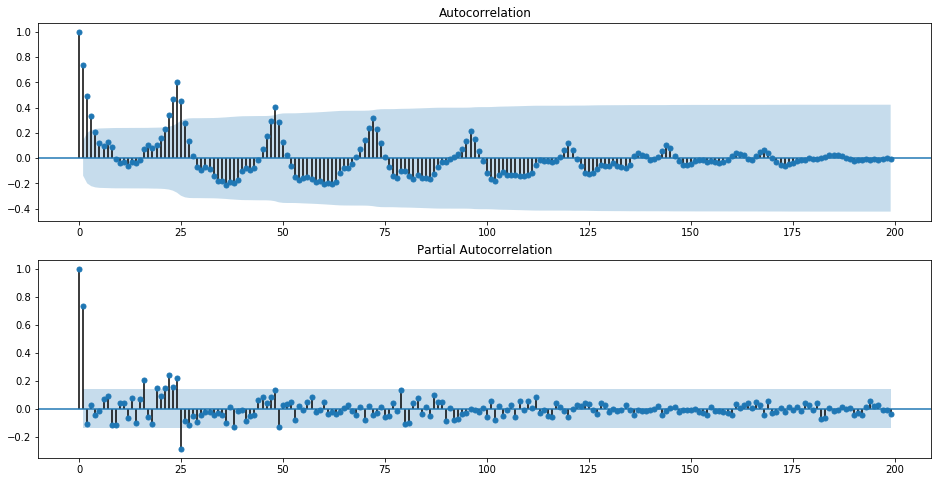

In [86]:
# Calculate ACF and PACF 

plt.figure(figsize=(16,8))
plt.subplot(211)
cpu_inter_start = cpu_inter.iloc[0:200]
plot_acf(cpu_inter_start, ax=plt.gca())
plt.subplot(212)
plot_pacf(cpu_inter_start, ax=plt.gca())
plt.show()

The ACF and PACF plots provide useful information about the type of models that are appropriate for this time series. 


The analysis suggests an ARIMA(p,d,0) model is appropriate based on the following observations:
- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in PACF, but none beyond lag q.

Furthermore, the ACF shows that there is no signficant correlations past the first 5 values, so we can try a range of values e.g 3-10 for the order of the autoregression (p). 

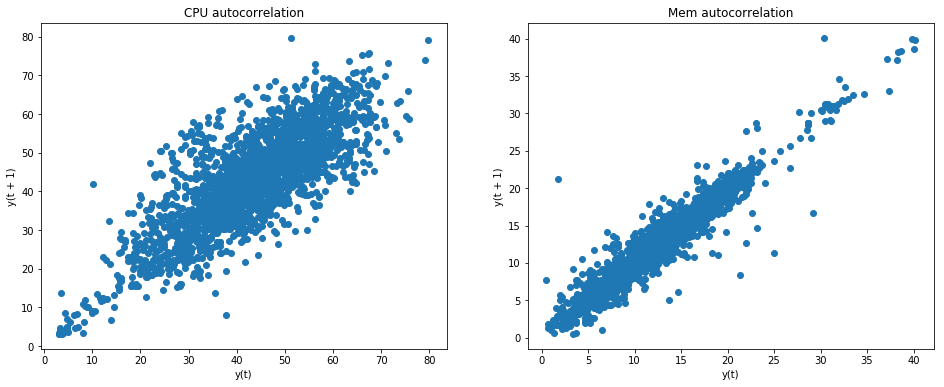

In [10]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax=lag_plot(cpu['avg(Value)'], ax=ax1)
ax.set_title('CPU autocorrelation')
axx=lag_plot(mem['avg(Value)'], ax=ax2)
axx.set_title('Mem autocorrelation')
plt.show()

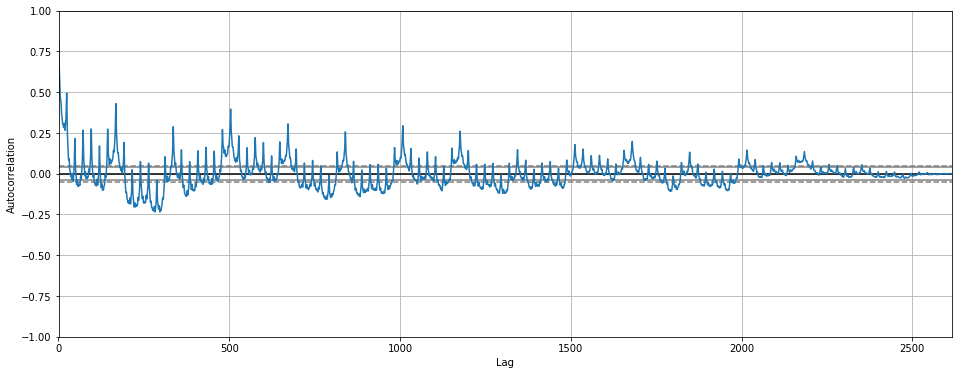

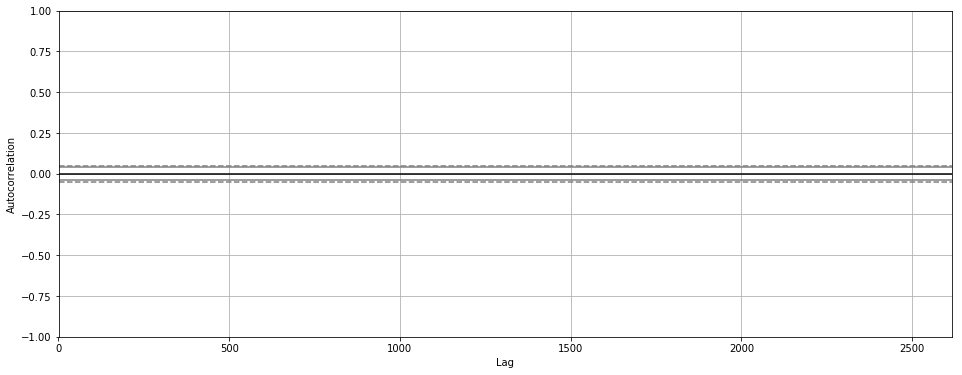

In [84]:
# CPU

plt.figure(figsize=(16,6))

autocorrelation_plot(cpu_inter['avg(Value)'])
plt.show()
plt.figure(figsize=(16,6))
autocorrelation_plot(mem_inter['avg(Value)'])
plt.show()

### ARIMA Model - CPU 

We can try a range of values, or a grid search, to generate a series of candidate models. The models will be evaluated using the following metrics:
- AIC
- BIC
- Test MSE 

The first step is to split the data into training (2/3) and test sets (1/3).

In [99]:
# split into train and test sets
X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]
test = test[0:10]
test

array([37.83333333, 45.83333333, 47.83333333, 49.16666667, 51.        ,
       46.16666667, 50.        , 39.16666667, 39.16666667, 48.83333333])

In [89]:
X.shape

(2615,)

In [167]:
# Generate an evaluation function 

def run_model(X, order):
    # train autoregression
    size = int(len(X) * 0.66)
    train, test = X[:size], X[size:len(X)]
    test = test[0:10]
   # print(test)
    predictions = []
    history = [x for x in train]
    for i in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
#        residuals = pd.DataFrame(model_fit.resid)
        yhat = model_fit.forecast()[0]
        history.append(test[i])
        predictions.append(yhat)
    mse = metrics.mean_squared_error(test, predictions)
    return mse

def grid_search(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    scores, orders = [],[]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = run_model(data, order)
                    scores.append(mse)
                    orders.append(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print("ARIMA order: %s, SCORE %0.3f" % (order, mse))
                    #print("parameters: p = %s, q = %s, d = %s" % (p,q,d))
                except:
                    continue
    print("Best ARIMA order: %s, BEST SCORE: %0.3f" % (best_cfg, best_score))
    return scores, orders
        

In [168]:
# Grid search

p_values = range(0,5)
d_values = range(0,2)
q_values = range(0,2)

cpu_inter.dropna(inplace=True)
X = cpu_inter['avg(Value)'].values
warnings.filterwarnings("ignore")
scores, orders = grid_search(X, p_values, d_values, q_values)
#order = (1,0,0)
#mse = run_model(X, order)
#print("error: %s" % mse)

ARIMA order: (0, 0, 0), SCORE 25.717
ARIMA order: (0, 0, 1), SCORE 21.237
ARIMA order: (0, 1, 0), SCORE 34.896
ARIMA order: (0, 1, 1), SCORE 33.727
ARIMA order: (1, 0, 0), SCORE 29.423
ARIMA order: (1, 0, 1), SCORE 29.399
ARIMA order: (1, 1, 0), SCORE 34.571
ARIMA order: (1, 1, 1), SCORE 28.196
ARIMA order: (2, 0, 0), SCORE 29.411
ARIMA order: (2, 0, 1), SCORE 27.948
ARIMA order: (2, 1, 0), SCORE 28.732
ARIMA order: (2, 1, 1), SCORE 27.536
ARIMA order: (3, 0, 0), SCORE 26.485
ARIMA order: (3, 0, 1), SCORE 26.475
ARIMA order: (3, 1, 0), SCORE 28.773
ARIMA order: (3, 1, 1), SCORE 26.138
ARIMA order: (4, 0, 0), SCORE 26.555
ARIMA order: (4, 0, 1), SCORE 25.975
ARIMA order: (4, 1, 0), SCORE 27.410
ARIMA order: (4, 1, 1), SCORE 26.083
Best ARIMA order: (0, 0, 1), BEST SCORE: 21.237


In [169]:
scores

[25.71668131071862,
 21.237088461439054,
 34.89599501364857,
 33.72688572125187,
 29.422930997695868,
 29.399484926480795,
 34.570959450530566,
 28.196154793658025,
 29.41051273419608,
 27.947627948187296,
 28.73232353695484,
 27.53560050679395,
 26.48468911471058,
 26.47506145250663,
 28.772630725764213,
 26.138244321316627,
 26.554903120013044,
 25.975161583611623,
 27.40989299215827,
 26.083203617406923]

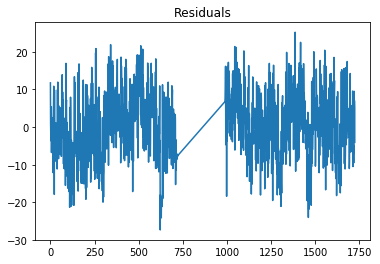

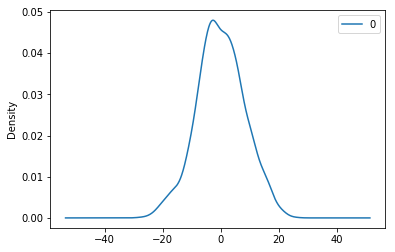

                 0
count  1725.000000
mean     -0.000429
std       8.249408
min     -27.301835
25%      -5.431548
50%      -0.230101
75%       5.586746
max      25.198875


<Figure size 1152x576 with 0 Axes>

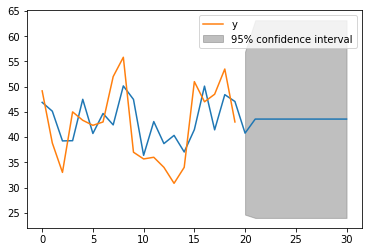

In [171]:
# train autoregression
model = ARIMA(train, order=(0,0,1))
#model_fit = model.fit()
# fit model
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

plt.figure(figsize=(16,8))
model_fit.plot_predict(start=len(train)-20, end=len(train)+10)
plt.show()

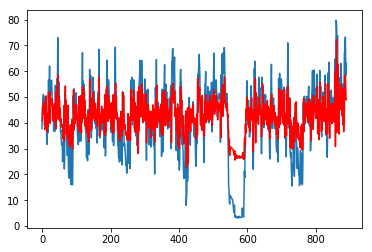

In [172]:
# Generate rolling forecast using the previously forecasted data points to recalculate the ARIMA model and generate predictions across the test set

X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]
#test = test[0:10]

predictions = []
history = [x for x in train]
for i in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit(disp=0)
#   residuals = pd.DataFrame(model_fit.resid)
    yhat = model_fit.forecast()[0]
    history.append(test[i])
    predictions.append(yhat)

mse = metrics.mean_squared_error(test, predictions)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

<Figure size 1152x576 with 0 Axes>

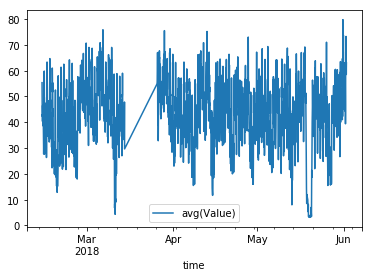

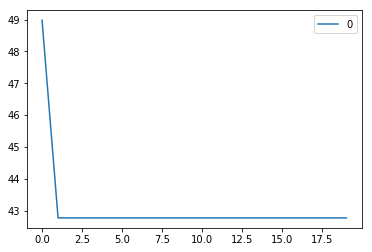

In [219]:
# Use the final fitted model from above to generate predictions 
pred = model_fit.forecast(steps=20)[0]
pred = pd.DataFrame(pred)
plt.figure(figsize=(16,8))
#ax1 = plt.subplot(211)
#ax2 = plt.subplot(212)
#model_fit.plot_predict(start=len(train)+600, end=len(train)+650)
cpu_inter.plot()
pred.plot()
plt.show()

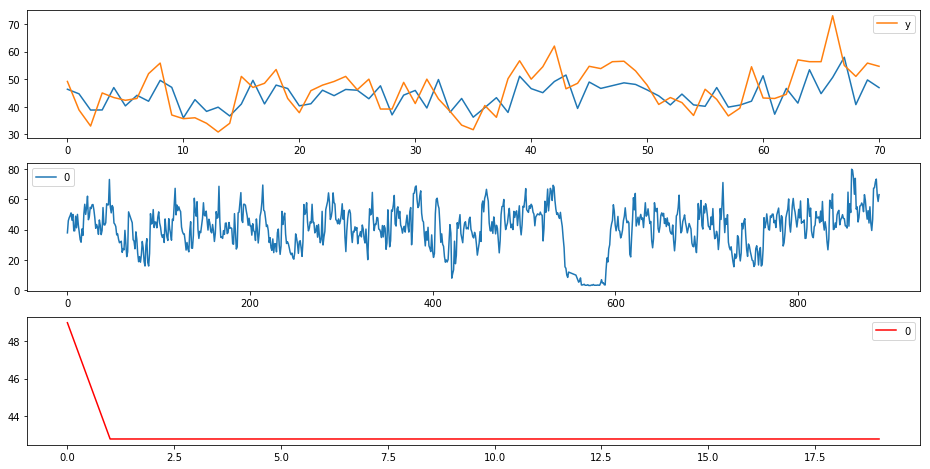

In [206]:
## Prediction
first_pred = model_fit.predict(start=len(train)-20, end=len(train)+50)
first_pred = pd.DataFrame(first_pred)
## Forecaset 

forecast = model_fit.forecast(steps=20)
forecast = pd.DataFrame(forecast[0])
plt.figure(figsize=(16,8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

model_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test = pd.DataFrame(test)
test.plot(ax=ax2, kind='line')
#first_pred = pd.DataFrame(first_pred)
#first_pred.plot(ax=ax1, kind='line')
forecast.plot(ax=ax3, kind='line', color='red')
plt.show()

### Original Models 

These models use 24 lags due to variations displayed over 24 h within the CPU time series. 

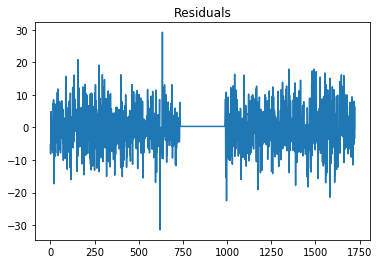

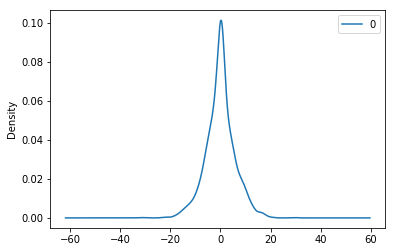

                 0
count  1724.000000
mean     -0.014202
std       5.794817
min     -31.488809
25%      -3.147771
50%       0.335450
75%       3.039379
max      29.285369


In [221]:
# train autoregression
model = ARIMA(train, order=(24,1,0))
#model_fit = model.fit()
# fit model
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<Figure size 1152x576 with 0 Axes>

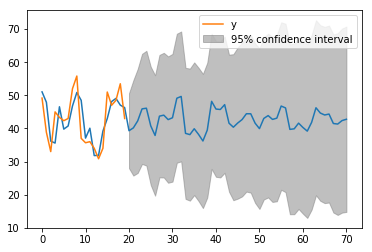

In [16]:
pred = model_fit.predict(start=len(train), end=len(train)+100)
#fig, ax = plt.subplots()
plt.figure(figsize=(16,8))
model_fit.plot_predict(start=len(train)-20, end=len(train)+50)
plt.show()

In [96]:
### Predict using date as well

train_time,test_time = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
train_time, test_time = train_time.set_index("_time"), test_time.set_index("_time")
train_time = train_time[1:]
#train_time
# train autoregression
model_time = ARIMA(train_time, order=(24,1,0))
#model_fit = model.fit()
# fit model
model_time_fit = model_time.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_time_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

KeyError: '_time'

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


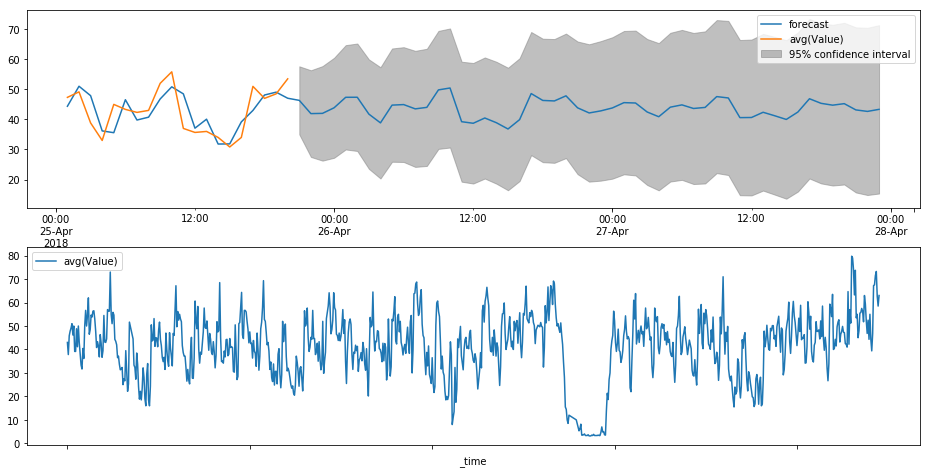

In [16]:
## Prediction
first_pred = model_time_fit.predict(start=len(train_time), end=len(train_time)+1)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

model_time_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.plot(ax=ax2, kind='line')
plt.show()



In [36]:
test['_time'].astype('datetime64[ns]')
test.dtypes

_time          object
avg(Value)    float64
dtype: object

In [50]:
print(train.shape)
print(test.shape)

(1725, 2)
(891, 2)


In [95]:
## Prediction

train,test = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
test['_time'].astype('datetime64[ns]')

first_pred = model_fit.predict(start=len(train), end=len(train)+500, typ='levels')
first_pred = pd.DataFrame(first_pred)
first_pred.columns = ['avg(Value)']
first_pred.index += 1725

plt.figure(figsize=(16,8))
ax1 = first_pred.plot(kind='line', color='red', title='Prediction')
#test.plot(ax=ax1, kind='line', color='blue', title='test')
train.plot(ax=ax1, kind='line', color='green', title='train')
plt.show()



KeyError: '_time'

Model Prediction/Forecasting

In [113]:
train, test = cpu_inter[0:size], cpu_inter[size:len(cpu_inter)]
#train = train[1:,1]
test = np.array(test['avg(Value)'])
test

array([37.83333333, 45.83333333, 47.83333333, 49.16666667, 51.        ,
       46.16666667, 50.        , 39.16666667, 39.16666667, 48.83333333,
       41.16666667, 50.        , 42.83333333, 38.33333333, 33.33333333,
       31.66666667, 40.44444444, 36.16666667, 50.16666667, 56.66666667,
       50.        , 54.5       , 62.        , 46.5       , 48.5       ,
       54.66666667, 53.83333333, 56.33333333, 56.5       , 53.        ,
       47.83333333, 40.83333333, 43.33333333, 41.5       , 36.83333333,
       46.33333333, 42.66666667, 36.66666667, 39.5       , 54.5       ,
       43.16666667, 43.        , 44.5       , 57.        , 56.33333333,
       56.33333333, 73.        , 55.        , 51.        , 55.83333333,
       54.66666667, 44.33333333, 43.5       , 42.        , 36.5       ,
       37.16666667, 33.66666667, 31.33333333, 31.66666667, 32.33333333,
       25.        , 27.5       , 26.66666667, 39.5       , 31.        ,
       22.16666667, 25.33333333, 51.66666667, 49.875     , 48.08

In [114]:
# split into 2/3 of data
size = int(len(cpu_inter) * 0.66)
train, test = cpu_inter[0:size], cpu_inter[size:len(cpu_inter)]
#train = train[1:,1]
history = [x for x in train['avg(Value)']]
test = np.array(test['avg(Value)'])
history = history[1:]
history
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    #t = 168 + i
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=39.303619, expected=37.833333
predicted=39.008126, expected=45.833333


KeyboardInterrupt: 

### AR Model - CPU

In [26]:
print("training shape:  " + str(train_time.shape))
#print("training dtype:  " + train_time.dtypes)
print("test shape:  " + str(test_time.shape))
# print("training dtype:  " + str(test_time.dtypes))


training shape:  (1724, 1)
test shape:  (891, 1)


In [27]:
# split into train and test sets
size = int(len(cpu_inter) * 0.66)
train_orig, test_orig = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
test_ar = np.array(test_orig)

Lag: 24
Coefficients: [ 2.33415600e+00  7.28016190e-01 -1.22258999e-01  1.16853721e-01
  1.52507675e-02 -7.87400816e-03 -2.29595711e-02  7.68538015e-02
  8.05809927e-03 -4.12262853e-02  2.34425890e-02  1.36021313e-02
 -4.66334480e-02  7.40673656e-02 -3.80725412e-02 -3.20522590e-02
  2.78711068e-02  4.56645541e-02 -8.19042466e-02 -1.03363980e-02
  1.33011639e-02  2.12672500e-03 -5.11918887e-02  1.29071973e-01
  1.26813873e-01]
Test MSE: 197.547


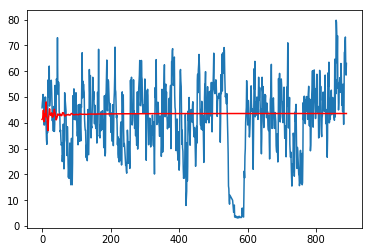

In [96]:
# train autoregression
test_ar = np.array(test_orig['avg(Value)'])
train = np.array(train_orig['avg(Value)'])
train = train[1:]
test_ar = test_ar[1:]
model_ar = AR(train)
model_ar_fit = model_ar.fit()
print('Lag: %s' % model_ar_fit.k_ar)
print('Coefficients: %s' % model_ar_fit.params)

# make predictions
predictions = model_ar_fit.predict(start=len(train), end=len(train)+len(test_ar)-1, dynamic=False)
#for i in range(len(predictions)):
#    print('predicted=%f, expected=%f' % (predictions[i], test_ar[i]))
error = metrics.mean_squared_error(test_ar, predictions)
print('Test MSE: %.3f' % error)
# plot results
#test_time['_time'].astype('datetime64[ns]')
pyplot.plot(test_ar)
pyplot.plot(predictions, color='red')
pyplot.show()



### Rolling model

Test MSE: 53.102


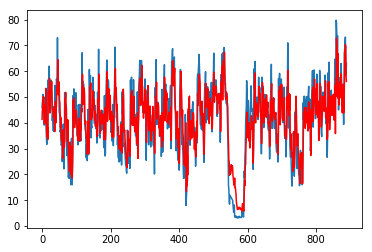

In [43]:
# train autoregression
model = AR(train)
model_fit = model.fit()
# number of coefficients i.e lag that is automatically determined
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
# the last 24 data points from train
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(test_ar, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test_ar)
#pyplot.plot(predictions, color='red')
pyplot.show()

### ARIMA Model - Mem

Joined Data Set

In [115]:
# split into train and test sets
#mem_inter.dropna(inplace=True)
#X = mem_inter['avg(Value)'].values
size_mem = int(len(mem_inter) * 0.66)
train_mem, test_mem = mem_inter[0:size], mem_inter[size:len(mem_inter)]

In [118]:
train_mem.head(1)

,_time,avg(Value)
0,2018-02-13T00:00:00.000+0000,NaN


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


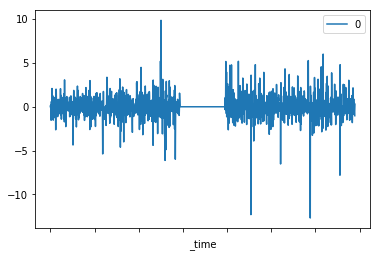

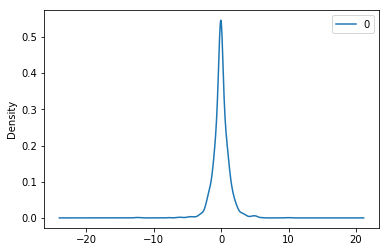

                 0
count  1724.000000
mean      0.000406
std       1.285168
min     -12.697503
25%      -0.528284
50%      -0.006145
75%       0.526848
max       9.853952


In [122]:
# train autoregression
train_mem[1:]
train_mem_time, test_mem_time = train_mem.set_index("_time"), test_mem.set_index("_time")
train_mem_time.dropna(inplace=True)
model_mem = ARIMA(train_mem_time, order=(24,1,0))

# fit model
model_mem_fit = model_mem.fit(disp=0)
#print(model_mem_fit.summary())
# plot residual errors
residuals_mem = pd.DataFrame(model_mem_fit.resid)
residuals_mem.plot()
pyplot.show()
residuals_mem.plot(kind='kde')
pyplot.show()
print(residuals_mem.describe())

Prediction

In [148]:
forecast[0]

array([11.71465868, 11.36058595, 10.39365101,  9.97094314,  9.4157416 ,
        9.25398793, 10.00294092,  9.85229249,  9.85758787,  9.29925654,
        8.99178061,  8.97856165,  9.31452209, 10.70967403, 11.18916326,
       11.41618647, 11.5854977 , 11.92824732, 11.74335685, 11.4950824 ])

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


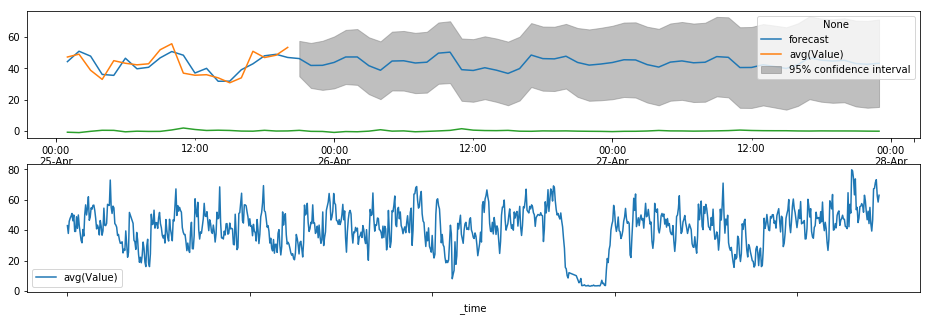

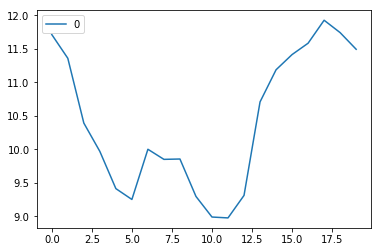

In [150]:
## Prediction
first_pred = model_mem_fit.predict(start=len(train_time)-20, end=len(train_time)+50, typ='linear')

## Forecaset 

forecast = model_mem_fit.forecast(steps=20)
forecast = pd.DataFrame(forecast[0])
plt.figure(figsize=(16,8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
#ax3 = plt.subplot(313)

model_time_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.plot(ax=ax2, kind='line')
#first_pred = pd.DataFrame(first_pred)
first_pred.plot(ax=ax1, kind='line')
forecast.plot(kind='line')
plt.show()

In [ ]:
# split into 2/3 of data
size = int(len(small_mem) * 0.66)
train, test = small[0:size], small[size:len(small)]
history = [x for x in train]
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    t = 168 + i
    obs = test[t]
    #history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test2, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test2)
pyplot.plot(predictions, color='red')
pyplot.show()